### Table of Contents
	
* [Importing libraries and cleaned data](#import)
* [EDA Visualizations](#visualizations)
    * [Numerical](#viz-numerical)
	* [Categorical](#viz-categorical)
* [Adding 2 additional features](#add-features)
* [Correlation heatmap for numerical features](#corr-numerical)
* [Correlation heatmap for categorical features](#corr-categorical)
* [Encoding categorical columns](#encoding)
* [Train/Test split](#train-test)
* [Random Forest model](#random-forest)

### Importing libraries and cleaned data  <a class="anchor" id="import"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import is_string_dtype,is_numeric_dtype
import scipy.stats as ss
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import OrdinalEncoder
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind

In [2]:
df = pd.read_csv('..\data\cleaned data.csv')

In [3]:
df.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


As a reminder, out target variable is 'income'.
<br>Income __above__ 50k is denominated with __value=1__
<br>Income __below__ 50k is denominated with __value=0__

### EDA Visualizations <a class="anchor" id="visualizations"></a>

In [4]:
# Separating columns in numerical and categorical
num_list = []
cat_list = []

for column in df:
    if is_numeric_dtype(df[column]):
        num_list.append(column)
    elif is_string_dtype(df[column]):
        cat_list.append(column)   
        
print(num_list)
print(cat_list)

['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'income']
['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']


Let's look at the distribution of our target variable (income)

In [5]:
# Setting seaborn plotting aesthetics as default
sns.set()

In [6]:
df['income'].value_counts(normalize=True)

0    0.760718
1    0.239282
Name: income, dtype: float64

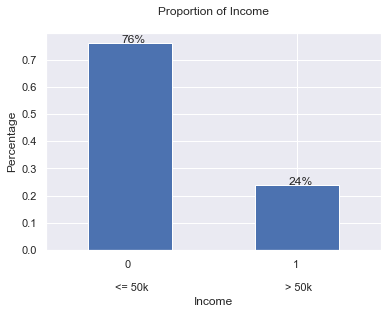

In [7]:
df['income'].value_counts(normalize=True).plot(kind='bar')
plt.title('Proportion of Income\n')
plt.ylabel('Percentage')
plt.xticks(ticks = [0,1], labels=['0 \n\n <= 50k','1 \n\n > 50k'], rotation=0)
plt.annotate('76%', (-0.05, 0.76) )
plt.annotate('24%', (0.95, 0.24) )
plt.xlabel('Income');

Let's explore the relation between our features and target variable income

### Numerical <a class="anchor" id="viz-numerical"></a>

In [8]:
print(num_list)

['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'income']


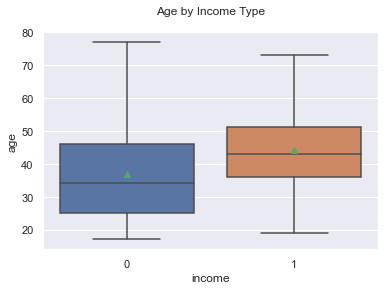

In [9]:
sns.boxplot(data=df, x='income', y='age', showfliers=False, showmeans=True)
plt.title('Age by Income Type\n');

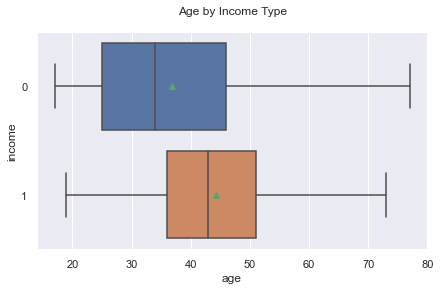

In [10]:
sns.set(rc={'figure.figsize':(7,4)})
sns.boxplot(data=df, x='age', y='income', showfliers=False, showmeans=True, orient='h')
plt.title('Age by Income Type\n');

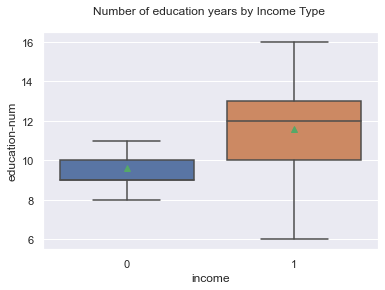

In [11]:
sns.set(rc={'figure.figsize':(6,4)})
sns.boxplot(data=df, x='income', y='education-num', showfliers=False, showmeans=True)
plt.title('Number of education years by Income Type \n');

In [12]:
# T-test
lower_educ = df[df['education-num'] < 10]['income']
higher_educ = df[df['education-num'] >= 10]['income']
ttest_ind(lower_educ, higher_educ)

Ttest_indResult(statistic=-53.497424589154186, pvalue=0.0)

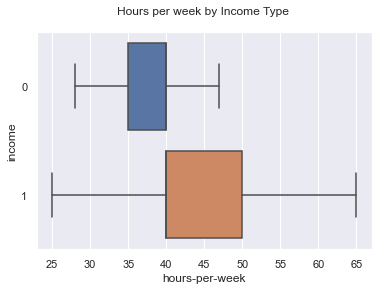

In [13]:
sns.boxplot(data=df, x='hours-per-week', y='income', showfliers=False, showmeans=False, orient='h')
plt.title('Hours per week by Income Type \n');

In [14]:
# T-test - higher hours are associated with high income
high_hours = df[df['hours-per-week'] >= 40]['income']
low_hours = df[df['hours-per-week'] < 40]['income']
ttest_ind(high_hours, low_hours)

Ttest_indResult(statistic=43.09155166464921, pvalue=0.0)

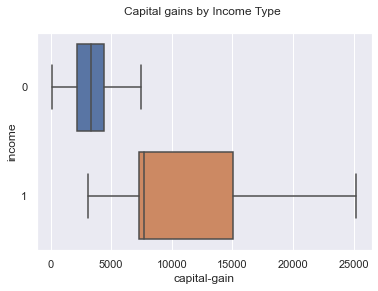

In [15]:
# For capital gains we're subsetting for capital gains above 0
sns.boxplot(data=df[df['capital-gain'] > 0], x='capital-gain', y='income', showfliers=False, orient='h')
plt.title('Capital gains by Income Type \n');

In [16]:
# T-test - capital gains of $7,000 or more are associated with high income
high_gains = df[df['capital-gain'] >= 7000]['income']
low_gains = df[df['capital-gain'] < 7000]['income']
ttest_ind(high_gains, low_gains)

Ttest_indResult(statistic=87.18677835706946, pvalue=0.0)

In [17]:
# Percent of people with capital gains higher than 0
df[df['capital-gain'] > 0].count()[0] / df[df['capital-gain'] <= 0].count()[0]

0.09005289352110162

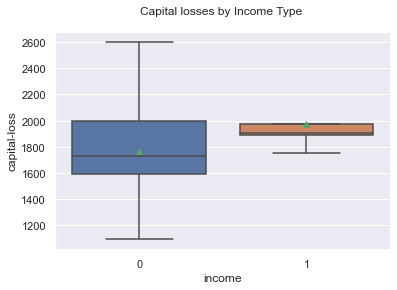

In [18]:
# For capital losses we're subsetting for capital losses above 0
sns.boxplot(data=df[df['capital-loss'] > 0], x='income', y='capital-loss', showfliers=False, showmeans=True)
plt.title('Capital losses by Income Type \n');

### Categorical <a class="anchor" id="viz-categorical"></a>
<br>For better visibility and customization, we'll plot them individually

In [19]:
print(cat_list)

['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']


In [20]:
sns.set(rc={'figure.figsize':(7,5)})

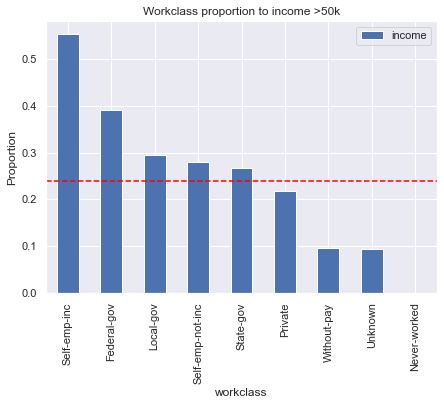

<Figure size 288x288 with 0 Axes>

In [21]:
df[['workclass','income']].groupby('workclass').mean().sort_values(by = 'income', ascending=False).plot(kind="bar")
plt.axhline(df.income.mean(), color="red", linestyle = '--')
plt.ylabel('Proportion')
plt.title('Workclass proportion to income >50k')
plt.figure(figsize=(4,4));

In [22]:
df['workclass'].value_counts(normalize=True).rename_axis('Workclass Type').reset_index(name='Percentage')

,Workclass Type,Percentage
0,Private,0.694198
1,Self-emp-not-inc,0.079071
2,Local-gov,0.064207
3,Unknown,0.057307
4,State-gov,0.040559
5,Self-emp-inc,0.034704
6,Federal-gov,0.029319
7,Without-pay,0.000430
8,Never-worked,0.000205


In [23]:
# Building contingency table for chi square test - Self-emp-inc has highest proportion of high income
contingency_workclass = pd.crosstab(df['income'],df['workclass'].isin(['Self-emp-inc']))

# Chi square test
chi2, p, dof, expected = chi2_contingency(contingency_workclass)
print('p-value:',p)

p-value: 1.3250966032219113e-208


In [24]:
# Building contingency table for chi square test - Private is below the mean if high income
contingency_workclass_2 = pd.crosstab(df['income'],df['workclass'].isin(['Private']))

# Chi square test
chi2, p, dof, expected = chi2_contingency(contingency_workclass_2)
print('p-value:',p)

p-value: 1.2707844704819995e-62


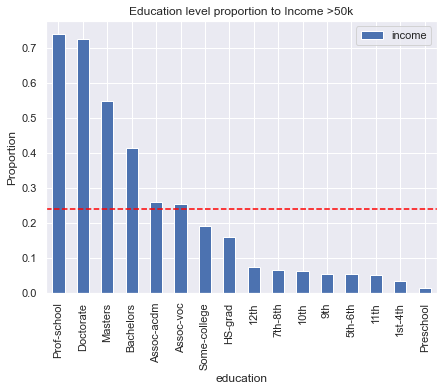

In [25]:
df[['education','income']].groupby('education').mean().sort_values(by = 'income', ascending=False).plot(kind="bar")
plt.axhline(df.income.mean(), color="red", linestyle = '--')
plt.ylabel('Proportion')
plt.title('Education level proportion to Income >50k');

In [26]:
# Building contingency table for chi square test - 4 highest degrees have the highest proportion of high income
contingency_education = pd.crosstab(df['income'],df['education'].isin(['Prof-school','Doctorate','Masters','Bachelors']))

# Chi square test
chi2, p, dof, expected = chi2_contingency(contingency_education)
print('p-value:',p)

p-value: 0.0


In [27]:
df[['education-num','education']].groupby('education').mean().sort_values(by='education-num')[-7:].rename(columns={'education-num':'Number of education years'})

,Number of education years
education,
Some-college,10
Assoc-voc,11
Assoc-acdm,12
Bachelors,13
Masters,14
Prof-school,15
Doctorate,16


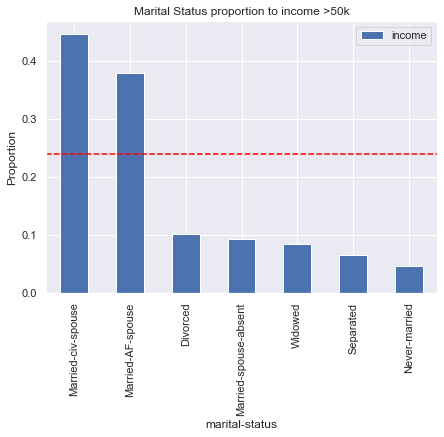

In [28]:
df[['marital-status','income']].groupby('marital-status').mean().sort_values(by = 'income', ascending=False).plot(kind="bar")
plt.axhline(df.income.mean(), color="red", linestyle = '--')
plt.ylabel('Proportion')
plt.title('Marital Status proportion to income >50k');

In [29]:
# Building contingency table for chi square test - better probability of high income if you’re married
contingency_marital = pd.crosstab(df['income'],df['marital-status'].isin(['Married-civ-spouse',\
                                                                          'Married-AF-spouse','Married-spouse-absent']))

# Chi square test
chi2, p, dof, expected = chi2_contingency(contingency_marital)
print('p-value:',p)

p-value: 0.0


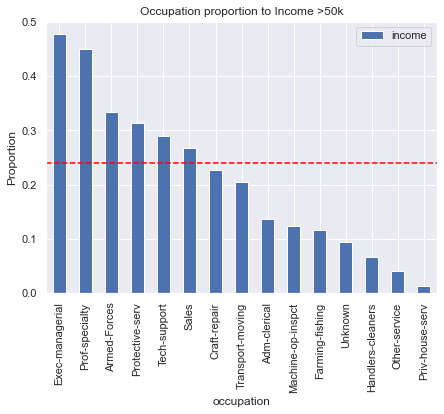

In [30]:
df[['occupation','income']].groupby('occupation').mean().sort_values(by = 'income', ascending=False).plot(kind="bar")
plt.axhline(df.income.mean(), color="red", linestyle = '--')
plt.ylabel('Proportion')
plt.title('Occupation proportion to Income >50k');

In [31]:
# Building contingency table for chi square test
# Exec-managerial and Prof-specialty are the occupations with a higher proportion of high income
contingency_occupation = pd.crosstab(df['income'],df['occupation'].isin(['Exec-managerial','Prof-specialty']))

# Chi square test
chi2, p, dof, expected = chi2_contingency(contingency_occupation)
print('p-value:',p)

p-value: 0.0


In [32]:
df['occupation'].value_counts(normalize=True).rename_axis('Occupation').reset_index(name='Percentage')

,Occupation,Percentage
0,Prof-specialty,0.126367
1,Craft-repair,0.125138
2,Exec-managerial,0.124606
3,Adm-clerical,0.114881
4,Sales,0.112690
5,Other-service,0.100794
6,Machine-op-inspct,0.061873
7,Unknown,0.057512
8,Transport-moving,0.048217
9,Handlers-cleaners,0.042423


In [33]:
contingency_occupation = pd.crosstab(df['income'],df['occupation'].isin(['Exec-managerial','Prof-specialty']))
contingency_occupation

occupation,False,True
income,,
0,30589,6566
1,5995,5692


In [34]:
# Chi square testing
chi2, p, dof, expected = chi2_contingency(contingency_education)
print('p-value:',p)

p-value: 0.0


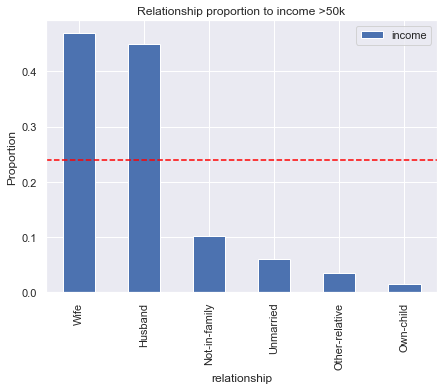

In [35]:
df[['relationship','income']].groupby('relationship').mean().sort_values(by = 'income', ascending=False).plot(kind="bar")
plt.axhline(df.income.mean(), color="red", linestyle = '--')
plt.ylabel('Proportion')
plt.title('Relationship proportion to income >50k');

In [36]:
# Building contingency table for chi square test - better probability of high income if you’re married
contingency_relationship = pd.crosstab(df['income'],df['relationship'].isin(['Wife','Husband']))

# Chi square test
chi2, p, dof, expected = chi2_contingency(contingency_relationship)
print('p-value:',p)

p-value: 0.0


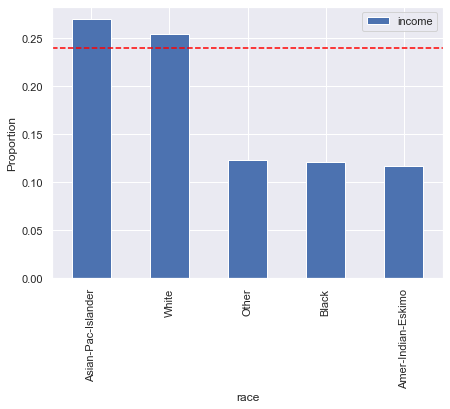

In [37]:
df[['race','income']].groupby('race').mean().sort_values(by = 'income', ascending=False).plot(kind="bar")
plt.axhline(df.income.mean(), color="red", linestyle = '--')
plt.ylabel('Proportion');

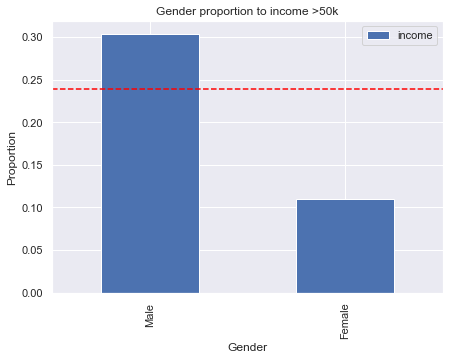

In [38]:
df[['sex','income']].groupby('sex').mean().sort_values(by = 'income', ascending=False).plot(kind="bar")
plt.axhline(df.income.mean(), color="red", linestyle = '--')
plt.ylabel('Proportion')
plt.xlabel('Gender')
plt.title('Gender proportion to income >50k');

In [39]:
df['sex'].value_counts(normalize=True).rename_axis('Gender').reset_index(name='Percentage')

,Gender,Percentage
0,Male,0.668482
1,Female,0.331518


In [40]:
# Building contingency table for chi square test - male almost triples the probability of higher income over being female
contingency_sex = pd.crosstab(df['income'],df['sex'].isin(['Male']))

# Chi square test
chi2, p, dof, expected = chi2_contingency(contingency_sex)
print('p-value:',p)

p-value: 0.0


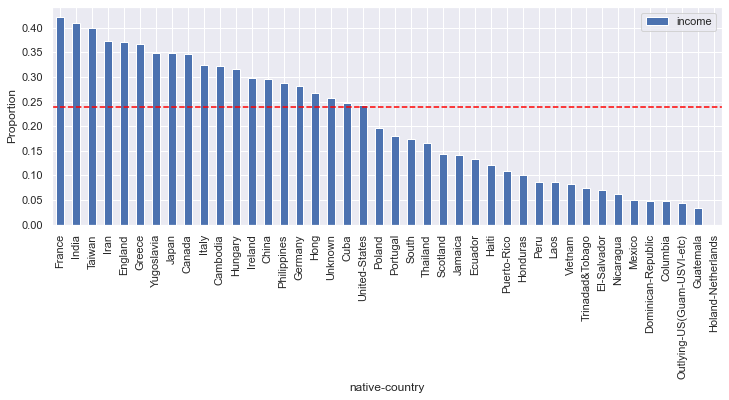

In [41]:
sns.set(rc={"figure.figsize":(12, 4)}) 
df[['native-country','income']].groupby('native-country').mean().sort_values(by = 'income', ascending=False).plot(kind="bar")
plt.axhline(df.income.mean(), color="red", linestyle = '--')
plt.ylabel('Proportion');

### Adding 2 additional features (bucketing for age and hours-per-week)<a class="anchor" id="add-features"></a>

In [42]:
age_bins = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
age_labels = ['10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100']
df['age_range'] = pd.cut(df['age'], bins=age_bins, labels=age_labels)

In [43]:
hours_worked_labels = ['1 - 20', '20 - 35', '35 - 40', '40 - 45', '45 - 50', '50 - 55', '55 - 99']
df['hours_worked_range'] = pd.qcut(df['hours-per-week'], q=11, duplicates='drop', labels=hours_worked_labels)

In [44]:
# Displaying the new columns
df.head(3)

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,age_range,hours_worked_range
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0,30-40,35 - 40
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0,40-50,1 - 20
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0,30-40,35 - 40


In [45]:
sns.set(rc={'figure.figsize':(7,5)})

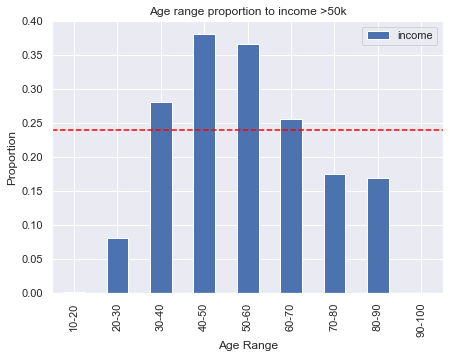

In [46]:
df[['age_range','income']].groupby('age_range').mean().plot(kind="bar")
plt.axhline(df.income.mean(), color="red", linestyle = '--')
plt.ylabel('Proportion')
plt.xlabel('Age Range')
plt.title('Age range proportion to income >50k');

In [47]:
df['age_range'].value_counts(normalize=True).rename_axis('Age Range').reset_index(name='Percentage').sort_values('Age Range')

,Age Range,Percentage
4,10-20,0.074178
1,20-30,0.249171
0,30-40,0.262848
2,40-50,0.212993
3,50-60,0.126981
5,60-70,0.056058
6,70-80,0.014741
7,80-90,0.003030
8,90-100,0.000000


In [48]:
# Building contingency table for chi square test - ages 40 to 60 have higher proportions of high income
contingency_age_range = pd.crosstab(df['income'],df['age_range'].isin(['40-50','50-60']))

# Chi square test
chi2, p, dof, expected = chi2_contingency(contingency_age_range)
print('p-value:',p)

p-value: 0.0


In [49]:
# Building contingency table for chi square test - we then see a decline after 60 years
contingency_age_range_2 = pd.crosstab(df['income'],df['age_range'].isin(['60-70','70-80','80-90','90-100']))

# Chi square test
chi2, p, dof, expected = chi2_contingency(contingency_age_range_2)
print('p-value:',p)

p-value: 0.6452767620597035


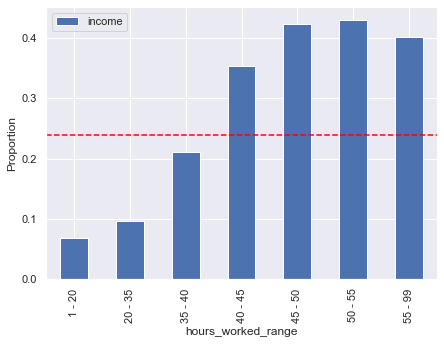

In [50]:
df[['hours_worked_range','income']].groupby('hours_worked_range').mean().plot(kind="bar")
plt.axhline(df.income.mean(), color="red", linestyle = '--')
plt.ylabel('Proportion');

In [51]:
df['hours_worked_range'].value_counts(normalize=True).rename_axis('hours_worked_range').reset_index(name='Percentage').sort_values('hours_worked_range')

,hours_worked_range,Percentage
3,1 - 20,0.091172
1,20 - 35,0.120368
0,35 - 40,0.494615
5,40 - 45,0.074751
2,45 - 50,0.107817
6,50 - 55,0.028193
4,55 - 99,0.083084


### Correlation heatmap for numerical features<a class="anchor" id="corr-numerical"></a>

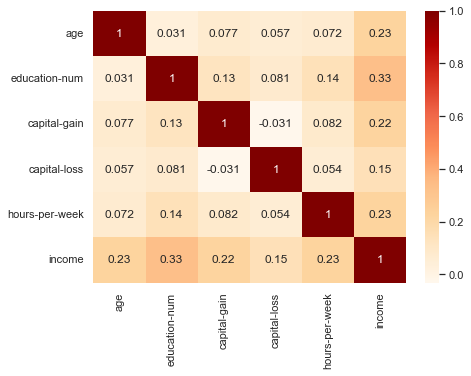

In [52]:
# plotting correlation heatmap for numerical variables
sns.heatmap(df[num_list].corr(), cmap='OrRd', annot=True);

### Correlation heatmap for categorical features<a class="anchor" id="corr-categorical"></a>

Since we can't get correlation between categorical variables, we'll use this function for Cramers V

In [53]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [54]:
# Adding 2 new columns to cat_list
cat_list.extend(('age_range','hours_worked_range'))

In [55]:
# Creating an extended categtory list and adding "income" to see also correlation to target variable
cat_list_corr = cat_list
cat_list_corr.append(('income'))
print(cat_list_corr)

['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'age_range', 'hours_worked_range', 'income']


In [56]:
# Creating dataframe to capture correlation values from categorical features
corr_cat = pd.DataFrame(index=cat_list_corr, columns=cat_list_corr)

In [57]:
# Cycling thru categorical features to obtain correlation using Cramers V function
for cat in corr_cat.index:
    for col in corr_cat.columns:
        corr_cat.loc[cat, col] = cramers_v(df[cat], df[col])

In [58]:
# Converting values from string to float
corr_cat = corr_cat.astype(float)

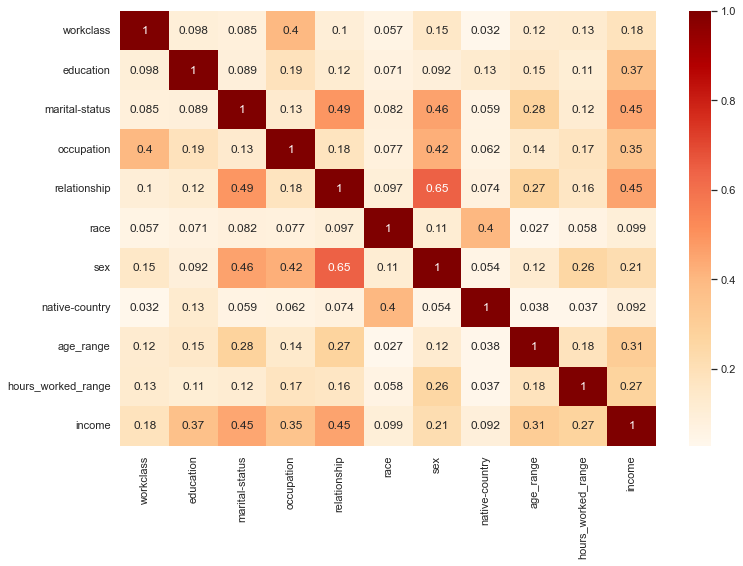

In [59]:
# plotting correlation heatmap for categorical variables
plt.figure(figsize = (12, 8))
sns.heatmap(corr_cat, cmap='OrRd', annot=True);

We can observe that marital status and relationship show a moderate correlation, which it’s expected since both features identify whether the person is married or not. Also there is a moderate to strong correlation between sex and relationship, this was unexpected. Let's explore further:

In [60]:
contingency = pd.crosstab(df['relationship'],df['sex'])
contingency

sex,Female,Male
relationship,,
Husband,1,19715
Not-in-family,5870,6713
Other-relative,689,817
Own-child,3376,4205
Unmarried,3928,1197
Wife,2328,3


An explanation of this correlation can be given by the fact that depending on your gender, this determines whether you're a husband or wife when you're married.

### Encoding categorical columns<a class="anchor" id="encoding"></a>

We'll encode the categorical columns in preparation for a Random Forest basic model we'll do to get feature importances. I tried using pandas get_dummies, but ended up with more than 100 columns which will not be easy for getting feature importance.

In [61]:
# Making a copy of our dataframe
df_encoded = df.copy()

In [62]:
# Creating an Ordinal Encoder instance
enc = OrdinalEncoder()

In [63]:
df_encoded[cat_list] = enc.fit_transform(df_encoded[cat_list])

In [64]:
df_encoded.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,age_range,hours_worked_range
0,39,6.0,9.0,13,4.0,0.0,1.0,4.0,1.0,2174,0,40,38.0,0.0,2.0,2.0
1,50,5.0,9.0,13,2.0,3.0,0.0,4.0,1.0,0,0,13,38.0,0.0,3.0,0.0
2,38,3.0,11.0,9,0.0,5.0,1.0,4.0,1.0,0,0,40,38.0,0.0,2.0,2.0
3,53,3.0,1.0,7,2.0,5.0,0.0,2.0,1.0,0,0,40,38.0,0.0,4.0,2.0
4,28,3.0,9.0,13,2.0,9.0,5.0,2.0,0.0,0,0,40,4.0,0.0,1.0,2.0


We can see now that our categorical features have been encoded

### Train/Test split<a class="anchor" id="train-test"></a>

In [65]:
X_train, X_test, y_train, y_test = train_test_split(df_encoded.drop(columns='income'),  
                                                    df_encoded.income, test_size=0.3, 
                                                    random_state=42)

In [66]:
X_train.shape, X_test.shape

((34189, 15), (14653, 15))

In [67]:
y_train.shape, y_test.shape

((34189,), (14653,))

### Random Forest model<a class="anchor" id="random-forest"></a>

We're creating a basic Random Forest model to get the feature importances of the model. Then we can compare with our findings from the visualizations.

In [68]:
rf_clf = RandomForestClassifier(random_state=42)

In [69]:
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [70]:
rf_clf.feature_importances_

array([0.17096843, 0.05308623, 0.0362243 , 0.09900565, 0.07327631,
       0.09075353, 0.10784726, 0.01808575, 0.01377617, 0.12417638,
       0.03935558, 0.07045597, 0.02356382, 0.04295501, 0.0364696 ])

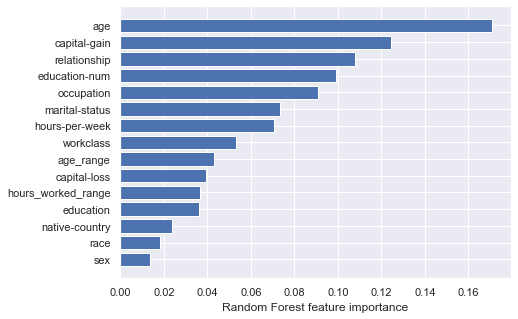

In [71]:
sorted_idx = rf_clf.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], rf_clf.feature_importances_[sorted_idx])
plt.xlabel('Random Forest feature importance');

In [72]:
# Cross validating to know the accuracy of the basic model
cv_results = cross_validate(rf_clf, X_train, y_train, cv=5)

In [73]:
np.mean(cv_results['test_score'])

0.8484308771376844